# Fundamental Usage

This example walks through creating and using an nnext index for nearest neighbor search.

It illustrates a few test cases to demonstrate the capabilities out of the box, and includes a visualization.

To follow along with this example in your own environment, run an nnext server locally, install the pynnext package (see the README), and install the additional dependencies required for the example notebooks declared in the `requirements.txt` file in this folder.

## Generic setup

In [1]:
# External imports
import numpy as np
import matplotlib.pyplot as plt

# Internal imports
import nnext

# Create and initialize a client to access locally-running, single-node server.
nnclient = nnext.Client(
    nodes=[
    {'host': 'localhost', 'port': '6040'}
  ])

## Creating an index, and searching for a query set

In [2]:
# Vector dimension of interest
n_dim = 768

# Create an vector index.
nnindex = nnclient.index.create(
    d=n_dim,
    name='test_index')

# Insert random vectors into the index.
n_vecs = 1000
vectors = np.random.rand(n_vecs, n_dim)
nnindex.add(vectors)

# Create a query vector set.
n_queries = 10
q_vectors = np.random.rand(n_queries, n_dim)

# Search for the k nearest neighbors of each vector
# in the query set, among the indexed vectors.
k = 5
_idx, _res = nnindex.search(q_vectors, k, return_vector=True)

# The search operation returns a 2d list of the indices of the nearest neighbors
# for each vector in the query set (i.e. shape (n_queries, k)), and optionally the data associated with
# the neighbor vectors themselves, i.e. nested list of shape (n_queries, k, n_dim), where entry (i, j, :) is the (n_dim)-dimensional
# vector corresponding to the jth nearest neighbor of query vector i
assert len(_idx) == n_queries
assert len(_idx[0]) == k
assert len(_res) == n_queries
assert len(_res[0]) == k
assert len(_res[0][0]) == n_dim

Adding batch [0:1000] size=3078012


### Again, with a Sanity Check:

In [3]:
# Vector dimension of interest
n_dim = 128

# Create an vector index.
nnindex = nnclient.index.create(
    d=n_dim,
    name='sanity_index')

# Create a query vector set.
n_queries = 10
q_vectors = np.random.rand(n_queries, n_dim)

# Insert the query vectors themselves into the index
nnindex.add(q_vectors)

# Followed by a bunch of random vectors.
n_vecs = 1000
vectors = np.random.rand(n_vecs, n_dim)
nnindex.add(vectors)

# Perform search against this index
k = 5
_idx, _res = nnindex.search(q_vectors, k, return_vector=True)

# If the nearest neighbor search works, we expect:
# 1. The index of the nearest vector to each query is the "index" of the query vector (i.e. it's index in the ordered list of all vectors inserted into the nnext index)
# 2. The actual vector asoccociated with the nearest neighbor of a query vector should be the query vector itself (since we've included them in the index). 
# We'll test this via vector norm, since equality of vectors is sensitive to storage reltated rounding errors, and may or may not work out in this particular case.
for idx, q in enumerate(q_vectors):
    nn = _res[idx][0] # supposed nearest neighbor
    nn_idx = int(_idx[idx][0]) # supposed idx of that neighbor

    # Test 1
    assert nn_idx == idx

    # Test 2
    eps = 1e-6
    assert np.linalg.norm(np.array(nn) - q) <= eps

Adding batch [0:10] size=5194
Adding batch [0:1000] size=518014


## Visualizing a Low Dimensional Example

In [4]:
# Vector dimension of interest
n_dim = 2

# Create an vector index.
nnindex = nnclient.index.create(
    d=n_dim,
    name='low_dim_index')

# Create a dataset with some well defined structure
tsteps = np.linspace(0, 100)
xs = np.array([t*np.cos(t) for t in tsteps])
ys = np.array([t*np.sin(t) for t in tsteps])
data = np.stack((xs, ys), axis=-1)

# Construct index for dataset
nnindex.add(data)

# A query
query = np.array([0,-25])

# Perform search for query against index
k = 5
_idx, _res = nnindex.search(query.reshape(1,-1), k, return_vector=True)

# Get indices of neighbors
nearest_indices = [int(idx) for idx in _idx[0]]

Adding batch [0:50] size=615


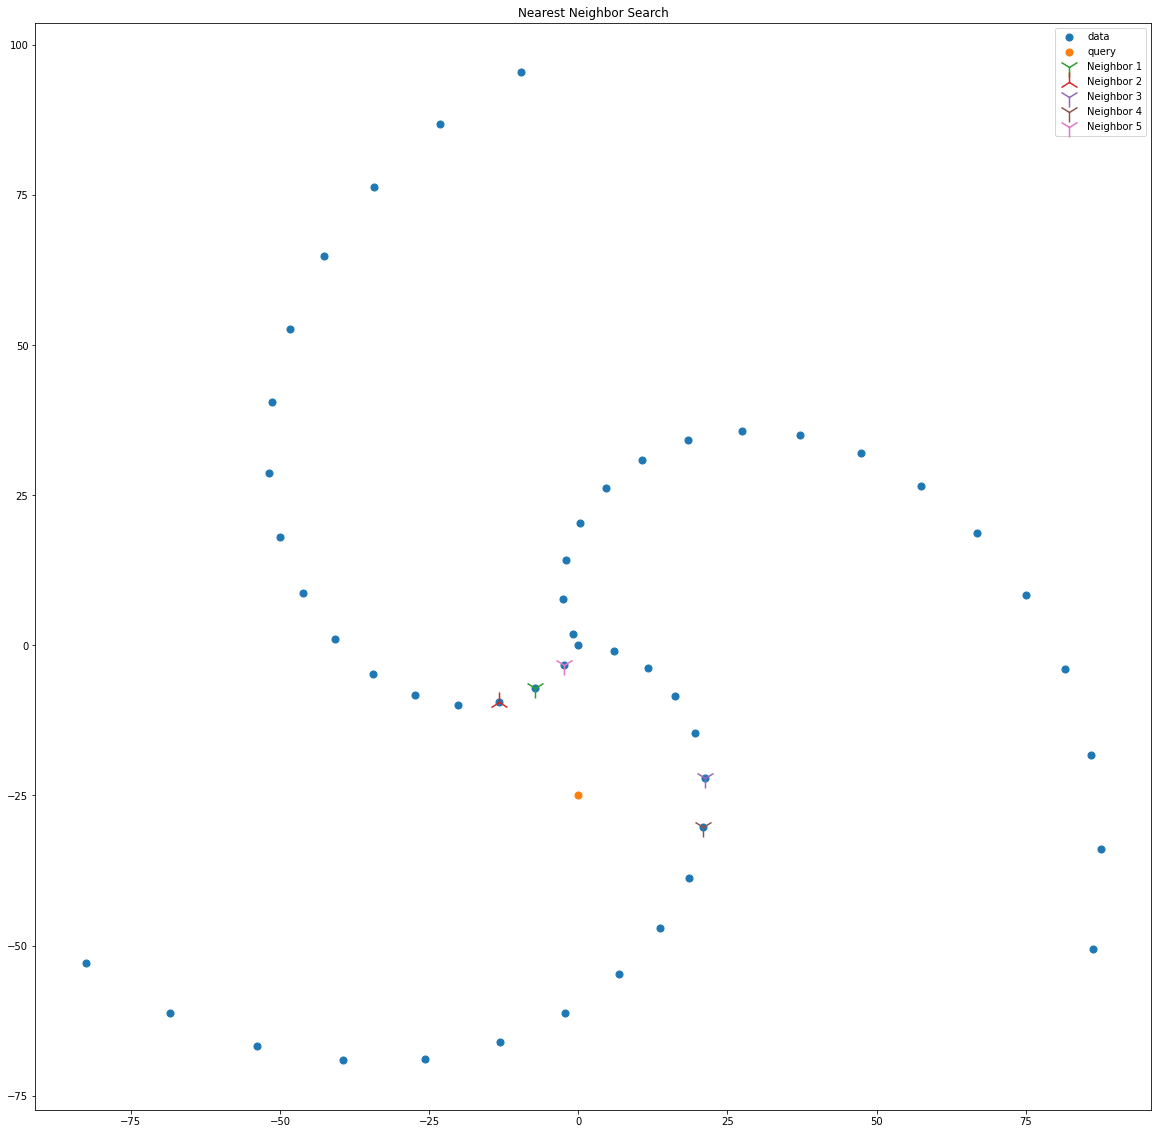

In [7]:
fig, ax = plt.subplots(figsize=(20,20))
ax.scatter(xs, ys, label="data", marker="o", s=50)
ax.scatter(query[0], query[1], label="query", s=50)
ax.scatter(data[nearest_indices[0]][0], data[nearest_indices[0]][1], label="Neighbor 1", marker="1", s=400)
ax.scatter(data[nearest_indices[1]][0], data[nearest_indices[1]][1], label="Neighbor 2", marker="2", s=400)
ax.scatter(data[nearest_indices[2]][0], data[nearest_indices[2]][1], label="Neighbor 3", marker="1", s=400)
ax.scatter(data[nearest_indices[3]][0], data[nearest_indices[3]][1], label="Neighbor 4", marker="1", s=400)
ax.scatter(data[nearest_indices[4]][0], data[nearest_indices[4]][1], label="Neighbor 5", marker="1", s=400)
plt.title("Nearest Neighbor Search")
ax.legend()
plt.show()
